In [1]:
import pyccl as ccl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
from cosmo_numba.B_modes.cosebis import COSEBIS

/Users/aguinot/Documents/cosmo-numba/cosmo_numba/B_modes/cosebis_nb.py:81: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  arr_tp_n_log[n, :] = tp_log_nb(z, roots_n[n], norms_n[n])
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10

mpl.rcParams['font.size'] = 20

mpl.rcParams['xtick.minor.size'] = 7
mpl.rcParams['ytick.minor.size'] = 7

mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3


mpl.rcParams['axes.xmargin'] = mpl.rcParamsDefault['axes.xmargin']

mpl.rcParams['axes.unicode_minus'] = True

color = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Cosmo model

In [4]:
def get_model(
    theta,
    z,
    nz,
    Omega_c,
    h,
    Omega_b,
    sig8,
    ns,
    B_amp,
    b_ia,
):

    theta_deg = theta/60

    cosmo = ccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        h=h,
        n_s=ns,
        sigma8=sig8,

        transfer_function='boltzmann_camb',
        matter_power_spectrum='camb',
        extra_parameters={
            "camb": {
                "halofit_version": 'mead2016',  # 'mead2020',
                "HMCode_A_baryon": B_amp,
                "kmax": 21,
                # We do this to avoid warnings in CAMB with (kmax < 5 or
                # 'kmax < 20 and z > 4') (set internally in ccl)
                # default: kmax=10
            }
        }
    )
    ccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = True

    lens = ccl.WeakLensingTracer(
        cosmo,
        dndz=(z, nz),
        ia_bias=(z, np.ones_like(z)*b_ia),
        use_A_ia=True,
    )

    # l_min = 30
    # l_max = 10_000
    l_min = 43
    l_max = 22_000
    l_bin = 1_000
    ell = np.logspace(np.log10(l_min), np.log10(l_max), l_bin)
    cl = ccl.angular_cl(cosmo, lens, lens, ell)

    xip_fit = ccl.correlation(
        cosmo,
        ell=ell,
        C_ell=cl,
        theta=theta_deg,
        type='GG+',
        method='fftlog',
    )
    xim_fit = ccl.correlation(
        cosmo,
        ell=ell,
        C_ell=cl,
        theta=theta_deg,
        type='GG-',
        method='fftlog'
    )

    #xi = np.concatenate((xip_fit, xim_fit))

    return xip_fit, xim_fit, ell, cl

In [5]:
def dist_nz(z, c_z):
    """
    eq 13 in https://iopscience.iop.org/article/10.3847/1538-4357/ac062f/pdf
    """
    return 0.5/c_z * (z/c_z)**2 * np.exp(-z/c_z)

## Set parameters

In [6]:
# Thin bins
tmin = 0.5
tmax = 250.
nbins = 10_000
print("nbins int:", nbins)

nbins int: 10000


In [7]:
# Planck cosmo 2018 | TT,TE,EE+lowE+lensing+BAO
h = 0.6766
Om = 0.3111
Ov = 0.6889
sig8 = 0.8102
ns = 0.9665
Ob_h2 = 0.02242
Ob = Ob_h2/h**2
Oc_h2 = 0.11933
Oc = Oc_h2/h**2
b_ia = 0.5
B_amp = 3.13

area = 1442.3673153360855
shape_noise = 0.30130993906642944
n_eff = 6.727816168552552
z = np.linspace(0, 3, 256)
c_z = 0.24
nz = dist_nz(z, c_z)

## Get $\xi_{\pm}$ model

In [8]:
theta_ = np.logspace(np.log10(tmin), np.log10(tmax), nbins+1)
theta = np.mean([theta_[:-1], theta_[1:]], axis=0)
dtheta = np.diff(theta_)

In [9]:
xip_model, xim_model, ell, Cell = get_model(
    theta,
    z,
    nz,
    Oc,
    h,
    Ob,
    sig8,
    ns,
    B_amp,
    b_ia,
)

## Compute roots and norms

In [10]:
N_mode = 20

In [11]:
cosebis = COSEBIS(theta_min=tmin, theta_max=tmax, N_max=N_mode)

In [12]:
cosebis._compute_roots()

In [13]:
C_E, C_B = cosebis.cosebis_from_xipm(theta, dtheta, xip_model, xim_model)

In [14]:
Tp_log = cosebis.get_Tp_log(theta)
Tm_log = cosebis.get_Tm_log(theta)

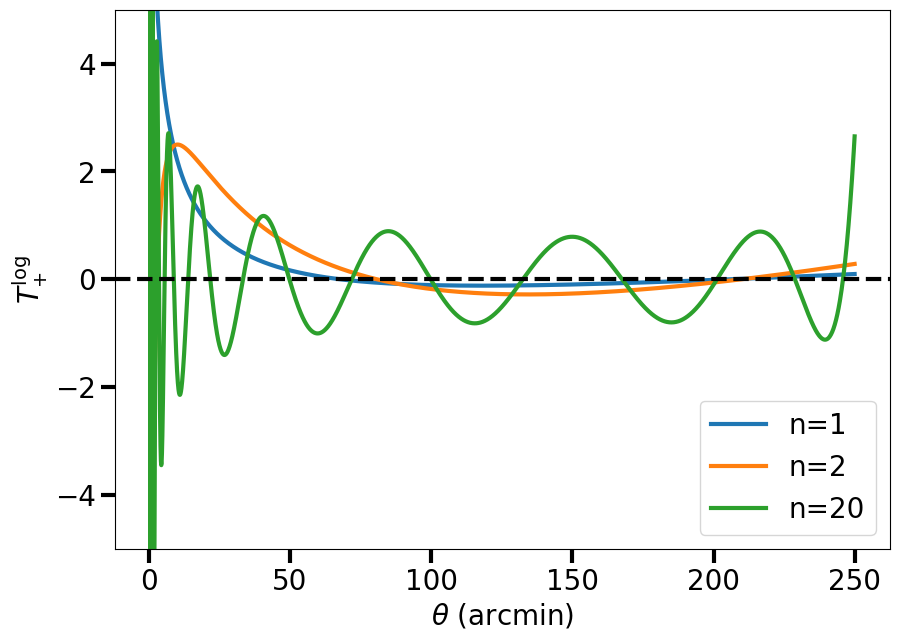

In [15]:
plt.figure(figsize=(10, 7))
plt.plot(theta, Tp_log[0], label="n=1")
plt.plot(theta, Tp_log[1], label="n=2")
plt.plot(theta, Tp_log[19], label="n=20")
plt.axhline(0, ls='--', color='k')
plt.ylim(-5, 5)
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$T_{+}^{\rm{log}}$")
plt.legend()

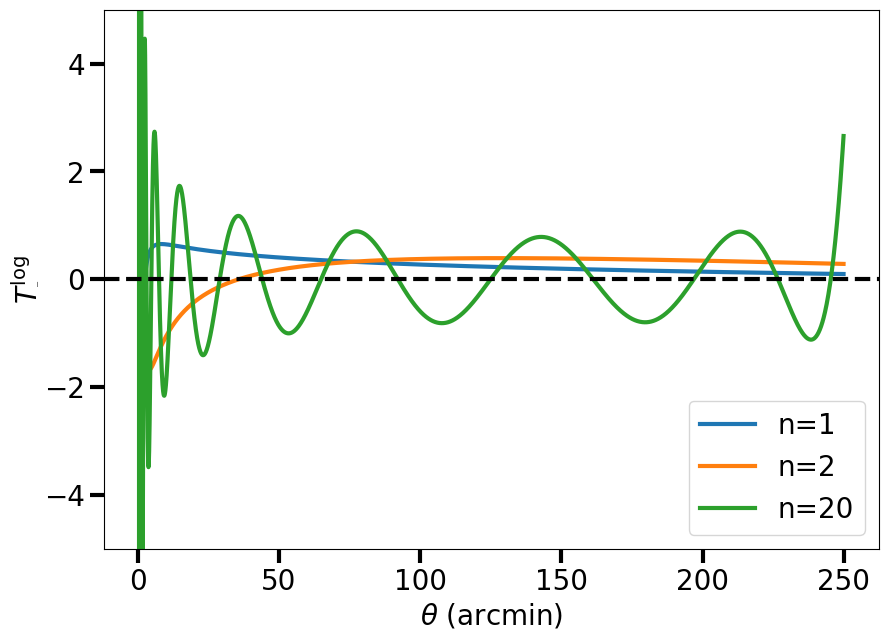

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(theta, Tm_log[0], label="n=1")
plt.plot(theta, Tm_log[1], label="n=2")
plt.plot(theta, Tm_log[19], label="n=20")
plt.axhline(0, ls='--', color='k')
plt.ylim(-5, 5)
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$T_{\text{-}}^{\rm{log}}$")
plt.legend()

## Compute E/B-modes

Text(0, 0.5, '$E/B$-mode')

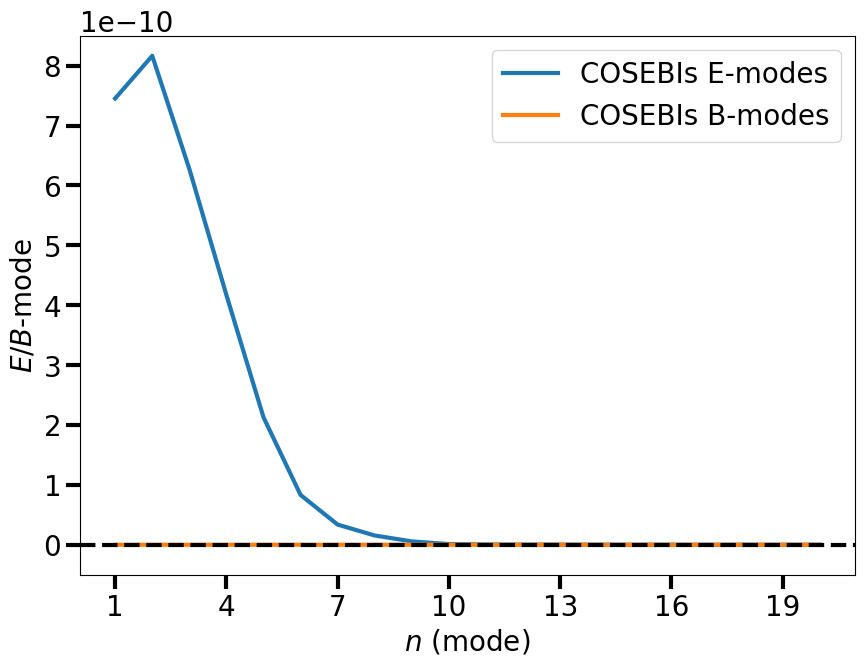

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(range(1, 21), C_E, color=color[0], label="COSEBIs E-modes")
plt.plot(range(1, 21), C_B, color=color[1], label="COSEBIs B-modes")
plt.axhline(0, ls='--', color="k")
plt.xticks(range(1, 21)[::3], range(1, 21)[::3])
plt.legend()
plt.ylim(-0.5e-10, 8.5e-10)
plt.xlabel(r"$n$ (mode)")
plt.ylabel(r"$E/B$-mode")

Text(0, 0.5, '$E$-mode')

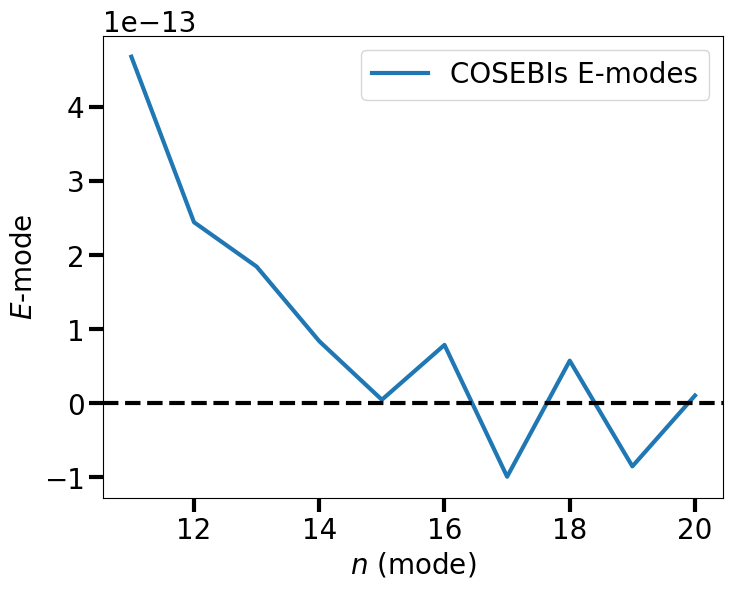

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21)[10:], C_E[10:], label="COSEBIs E-modes")
plt.axhline(0, ls='--', color="k")
plt.legend()
plt.xlabel(r"$n$ (mode)")
plt.ylabel(r"$E$-mode")

Text(0, 0.5, '$B$-mode')

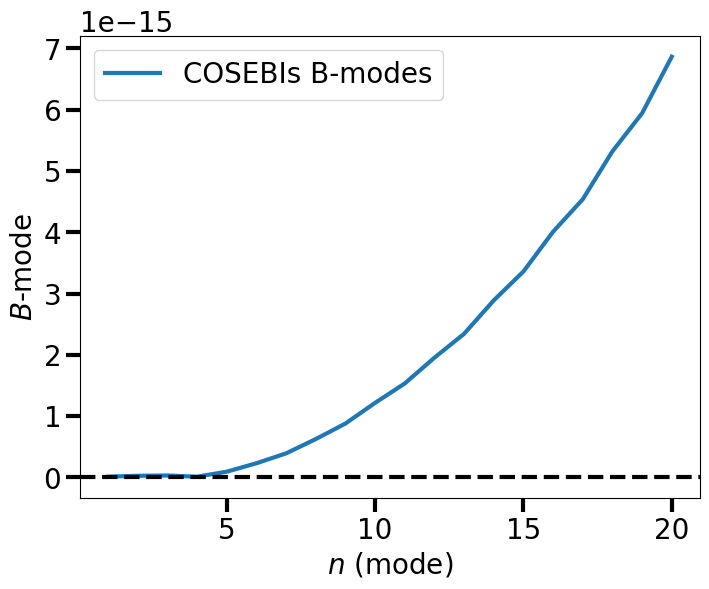

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), np.abs(C_B), label="COSEBIs B-modes")
plt.axhline(0, ls='--', color="k")
plt.legend()
plt.xlabel(r"$n$ (mode)")
plt.ylabel(r"$B$-mode")

In [20]:
Wn_log = cosebis.get_Wn_log(theta)

In [21]:
ell_ = np.logspace(np.log10(9), 3.5, 1000)

Text(0, 0.5, '$W_{n}^{\\rm{log}}(\\ell)$')

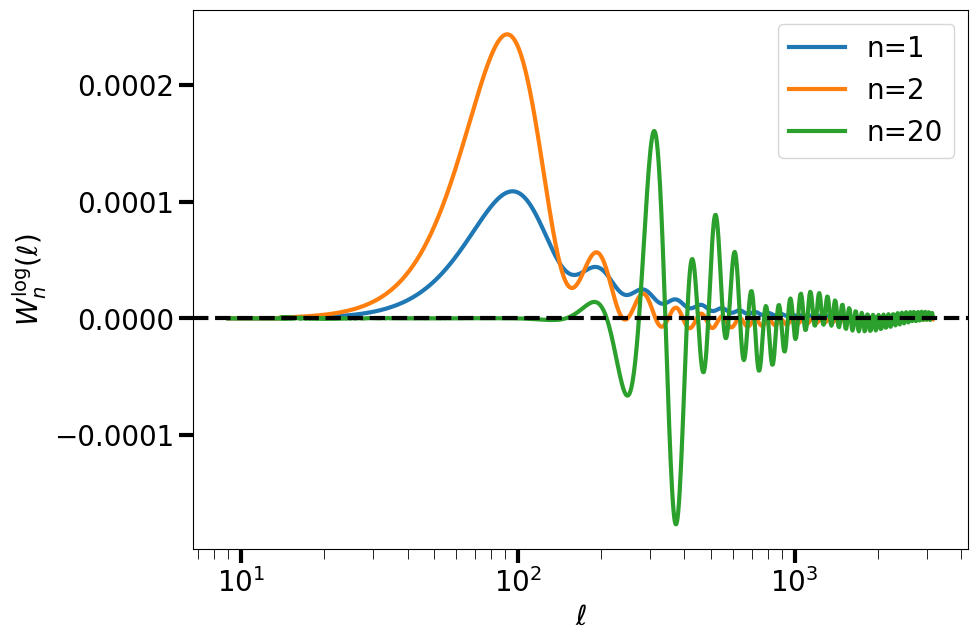

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(ell_, Wn_log[0].eval(ell_), label="n=1")
plt.plot(ell_, Wn_log[1].eval(ell_), label="n=2")
plt.plot(ell_, Wn_log[19].eval(ell_), label="n=20")
plt.axhline(0, ls='--', color="k")
plt.xscale("log")
plt.legend()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$W_{n}^{\rm{log}}(\ell)$")

In [23]:
C_E_l, C_B_l = cosebis.cosebis_from_Cell(ell, Cell, np.zeros_like(Cell), theta)

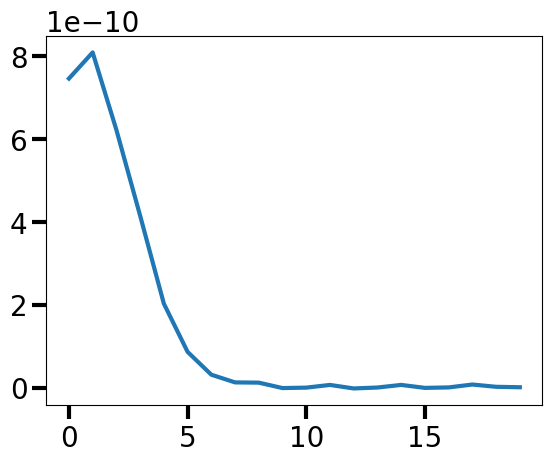

In [24]:
plt.plot(C_E_l)

## Compare COSEBIs computation

Text(0, 0.5, '$E/B$-mode')

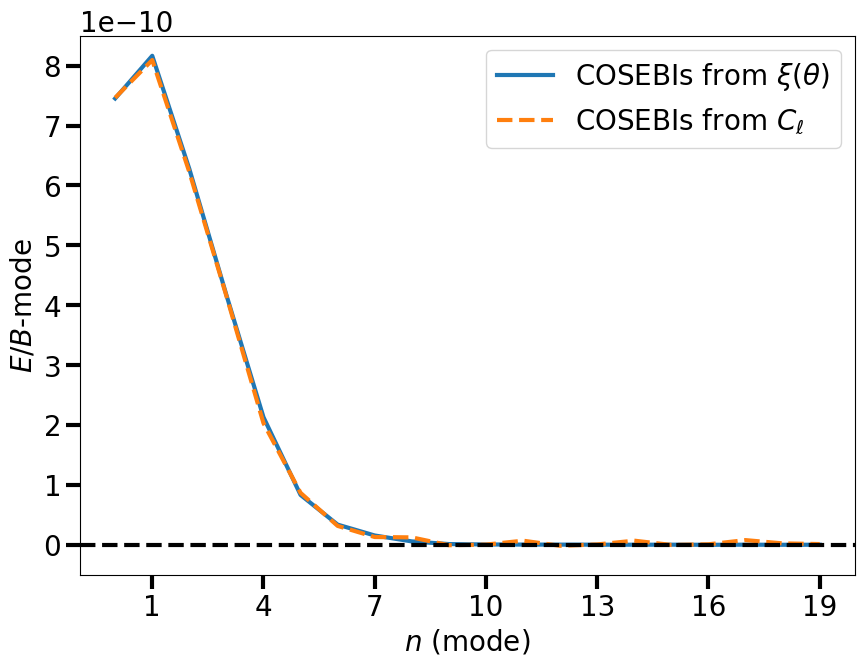

In [25]:
plt.figure(figsize=(10, 7))
plt.plot(C_E, label=r"COSEBIs from $\xi(\theta)$")
plt.plot(C_E_l, "--", label=r"COSEBIs from $C_{\ell}$")
plt.axhline(0, ls='--', color="k")
plt.legend()
plt.xticks(range(1, 21)[::3], range(1, 21)[::3])
plt.legend()
plt.ylim(-0.5e-10, 8.5e-10)
plt.xlabel(r"$n$ (mode)")
plt.ylabel(r"$E/B$-mode")

## Covariance

### Cov analytic

In [26]:
cov_pm = np.load("data/cov_shear_shear_cosmocov_0.5_250_1000.npy")

In [27]:
theta_cov_ = np.logspace(np.log10(0.5), np.log10(250), 1_000+1)
theta_cov = np.mean([theta_cov_[:-1], theta_cov_[1:]], axis=0)
dtheta_cov = np.diff(theta_cov_)

In [28]:
cov_EB = cosebis.cosebis_covariance_from_xipm_covariance(theta_cov, dtheta_cov, cov_pm)

In [29]:
Tp_log_cov_ = cosebis.get_Tp_log(theta_cov_)
Tp_log_cov = cosebis.get_Tp_log(theta_cov)

Text(0.5, 1.0, 'Cov EE')

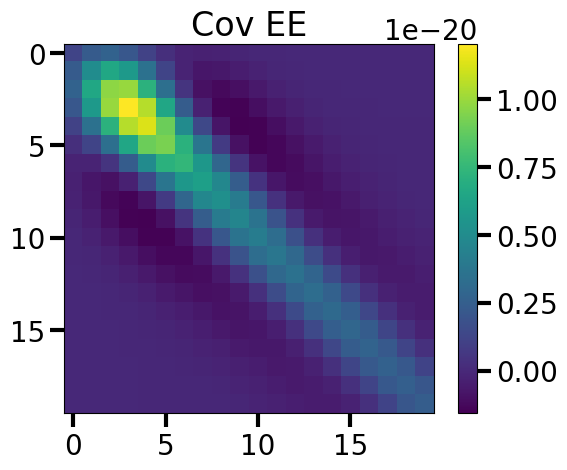

In [30]:
plt.imshow(cov_EB[:20, :20])
plt.colorbar()
plt.title("Cov EE")

Text(0.5, 1.0, 'Cov BB')

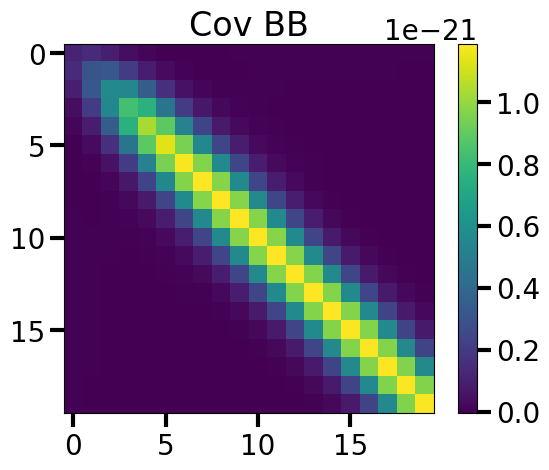

In [31]:
plt.imshow(cov_EB[20:, 20:])
plt.colorbar()
plt.title("Cov BB")

Text(0.5, 1.0, 'Full cov')

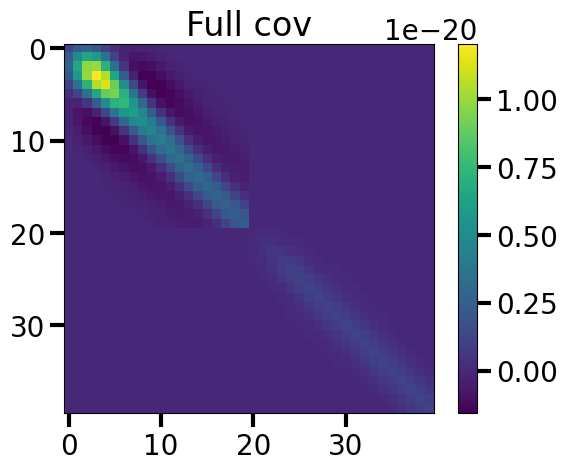

In [32]:
plt.imshow(cov_EB)
plt.colorbar()
plt.title("Full cov")

In [33]:
ndata = 40
pp_norm = np.zeros((ndata,ndata))
for i in range(ndata):
    for j in range(ndata):
        pp_norm[i,j] = cov_EB[i,j]/np.sqrt(cov_EB[i,i]*cov_EB[j,j])

Text(0.5, 1.0, 'Full cov')

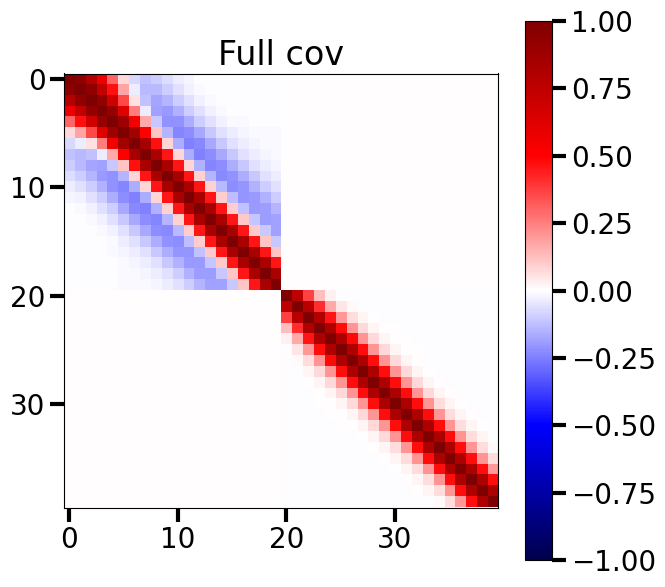

In [34]:
plt.figure(figsize=(7,7))
plt.imshow(pp_norm, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Full cov")

### Cov from sampling

In [35]:
n_sample = 5_000

In [36]:
xip_model_cov, xim_model_cov, ell_cov, Cell_cov = get_model(
    theta_cov,
    z,
    nz,
    Oc,
    h,
    Ob,
    sig8,
    ns,
    B_amp,
    b_ia,
)

In [37]:
rng = np.random.RandomState(42)
simu_xipm = rng.multivariate_normal(np.concatenate((xip_model_cov, xim_model_cov)), cov_pm, n_sample)

In [38]:
simu_xipm.shape

(5000, 2000)

In [39]:
all_C_E = np.empty((n_sample, 20), dtype=np.float64)
all_C_B = np.empty((n_sample, 20), dtype=np.float64)
for i in tqdm(range(n_sample)):
    all_C_E[i], all_C_B[i] = cosebis.cosebis_from_xipm(
        theta_cov,
        dtheta_cov,
        simu_xipm[i][:1_000],
        simu_xipm[i][1_000:]
    )

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [01:31<00:00, 54.55it/s]


In [40]:
v = np.concatenate((all_C_E, all_C_B), 1)
v -= np.mean(v, 0)
cov_EB_sampling = v.conj().T.dot(v)/(len(all_C_E)-1)

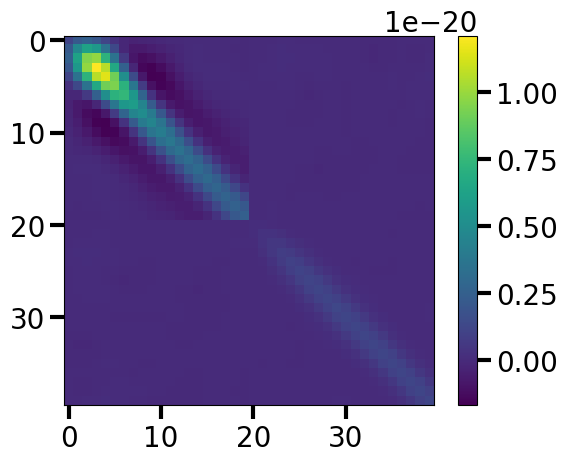

In [41]:
plt.imshow(cov_EB_sampling)
plt.colorbar()

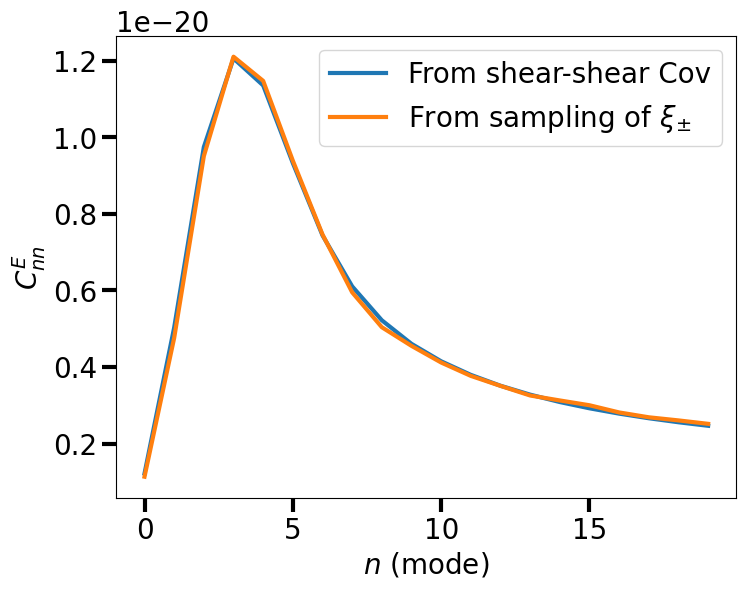

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(np.diag(cov_EB)[:20], label="From shear-shear Cov")
plt.plot(np.diag(cov_EB_sampling)[:20], label=r"From sampling of $\xi_{\pm}$")
plt.xlabel(r"$n$ (mode)")
plt.ylabel(r"$C^{E}_{nn}$")
plt.legend()

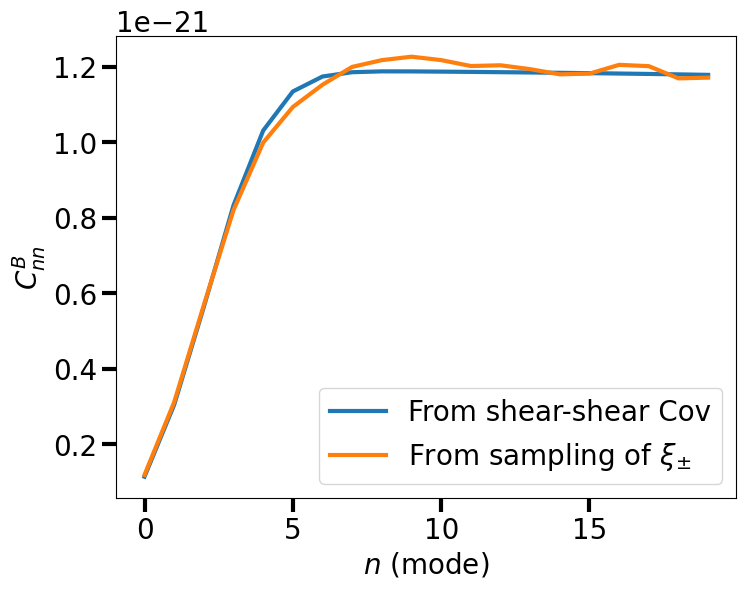

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(np.diag(cov_EB)[20:], label="From shear-shear Cov")
plt.plot(np.diag(cov_EB_sampling)[20:], label=r"From sampling of $\xi_{\pm}$")
plt.xlabel(r"$n$ (mode)")
plt.ylabel(r"$C^{B}_{nn}$")
plt.legend()

In [44]:
ndata = 40
pp_norm = np.zeros((ndata,ndata))
for i in range(ndata):
    for j in range(ndata):
        pp_norm[i,j] = cov_EB_sampling[i,j]/np.sqrt(cov_EB_sampling[i,i]*cov_EB_sampling[j,j])

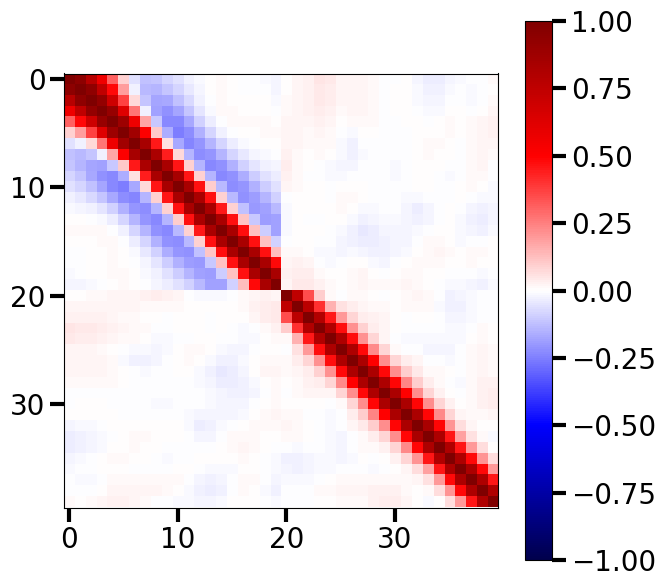

In [45]:
plt.figure(figsize=(7,7))
plt.imshow(pp_norm, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()